#Parkinsons Data

from the [UCI dataset](http://archive.ics.uci.edu/ml/datasets/Parkinsons)

"This dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson's disease (PD). Each column in the table is a particular voice measure, and each row corresponds one of 195 voice recording from these individuals ("name" column). The main aim of the data is to discriminate healthy people from those with PD, according to "status" column which is set to 0 for healthy and 1 for PD."

citation: Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2008), 'Suitability of dysphonia measurements for telemonitoring of Parkinson's disease', IEEE Transactions on Biomedical Engineering (to appear).

In [1]:
#pip installs
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install eli5
!pip install pdpbox
!pip install shap

     |████████████████████████████████| 81kB 3.4MB/s 
     |████████████████████████████████| 245kB 5.6MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 604kB 18.3MB/s 
     |████████████████████████████████| 71kB 6.9MB/s 
     |████████████████████████████████| 3.1MB 34.8MB/s 
     |████████████████████████████████| 296kB 51.1MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=174e1a11da2105863cfdbe097fdf08a2a7e291abe0f2d144ef3e68e872b9a46f
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built htmlmin
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
  

In [65]:
#Libraries
import pandas as pd
import numpy as np
from datetime import datetime 
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import eli5 
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from scipy.stats import randint, uniform

from sklearn.metrics import roc_curve, roc_auc_score

#Display settings
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

#Define ML Problems

The target is 'status', 1 = has Parkinsons, 0 = does not have Parkinsons.

This is a binary classification problem.

The target is imbalanced, I will use f1 score and the confusion matrix to measure the model.

I will use a random split to do a train/test split on the model, and use cross validation.



In [3]:
#Import the dataset
df = pd.read_csv('https://raw.githubusercontent.com/TemsyChen/Lambda_Unit2_Build/main/parkinsons.data')

df.head()

name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
0           0.00007   0.00370   0.00554     0.01109       0.04374   
1           0.00008   0.00465   0.00696     0.01394       0.06134   
2           0.00009   0.00544   0.00781     0.01633       0.05233   
3           0.00009   0.00502   0.00698     0.01505       0.05492   
4           0.00011   0.00655   0.00908     0.01966       0.06425   

   MDVP:Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  MDVP:APQ  Shimmer:DDA  \
0             0.426       0.02182       0.03130   0.02971      0.06545   
1             0.626       0.03134       0.04518   0.04368      0.09403   
2             0.482       0.02757       0.03858   0.03590      0.08270   
3             0.517       0.02924       0.04005   0.03772      0.08771   
4             0.584       0.03490       0.04825   0.04465      0.10470   

       NHR     HNR  status      RPDE       DFA   spread1   spread2        D2  \
0  0.02211  21.033       1  0.414783  0.815285 -4.813031  0.266482  2.301442   
1  0.01929  19.085       1  0.458359  0.819521 -4.075192  0.335590  2.486855   
2  0.01309  20.651       1  0.429895  0.825288 -4.443179  0.311173  2.342259   
3  0.01353  20.644       1  0.434969  0.819235 -4.117501  0.334147  2.405554   
4  0.01767  19.649       1  0.417356  0.823484 -3.747787  0.234513  2.332180   

        PPE  
0  0.284654  
1  0.368674  
2  0.332634  
3  0.368975  
4  0.410335

##EDA

##Data Documentation
Attribute Information:

Matrix column entries (attributes):

name - ASCII subject name and recording number

MDVP:Fo(Hz) - Average vocal fundamental frequency

MDVP:Fhi(Hz) - Maximum vocal fundamental frequency

MDVP:Flo(Hz) - Minimum vocal fundamental frequency

MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several 
measures of variation in fundamental frequency (ie pitch)

MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude (ie volume)

NHR,HNR - Two measures of ratio of noise to tonal components in the voice

status - Health status of the subject (one) - Parkinson's, (zero) - healthy

RPDE,D2 - Two nonlinear dynamical complexity measures

DFA - Signal fractal scaling exponent

spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation 


In [4]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True)

profile

Summarize dataset:   0%|          | 0/32 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

In [6]:
display(df.shape)
display(df.info())

(195, 24)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

None

#Prepare the data

The target is "status" for 0 = Healthy, and 1 = Has Parkinsons.

In [7]:
#Find baseline/majority class

df['status'].value_counts(normalize=True)

#75% have Parkinsons

1    0.753846
0    0.246154
Name: status, dtype: float64

In [8]:
#Do a train/test split on the data 90%, 10%
#After that I'll use cross validation because the data set is small
#or split the training data again to get a validation set

target = 'status'
features = df.columns[df.columns!='status'].to_list()

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1, stratify=df['status'], random_state=37)
#stratify to keep the same proportion of target values in each set

X_train.shape, y_train.shape, X_test.shape, y_test.shape                                  

((175, 23), (175,), (20, 23), (20,))

In [9]:
#Wrangle data
#drop unique ID

def wrangle(X):
  X = X.copy()

  X = X.drop(['name'], axis=1)

  return X

X_train = wrangle(X_train)
X_test = wrangle(X_test)

#Logistic Regression

In [10]:
#Try a logistic regression
#Scale the dataset

#without scaling the dataset, I get this warning:
#Increase the number of iterations (max_iter) or scale the data as shown in:
#     https://scikit-learn.org/stable/modules/preprocessing.html
# Please also refer to the documentation for alternative solver options:
#     https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
#   extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
# /usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
# STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
#Fit a logistic regression model
#The train set is small, use k-fold cross validation 

lr = LogisticRegression()

k = 10
scores = cross_val_score(lr, X_train_scaled, y_train, cv=k)

print(f'Accuracy score for {k} folds with Logistic Model 1:', scores)
print(f'Mean score:', scores.mean())

Accuracy score for 10 folds with Logistic Model 1: [0.83333333 0.83333333 0.77777778 0.83333333 0.83333333 0.94117647
 0.94117647 0.82352941 0.82352941 0.88235294]
Mean score: 0.8522875816993464


In [12]:
#Hyperparameter tuning 
#Randomized search CV

model = LogisticRegression()
solvers = ['newton-cg','lbfgs','liblinear']
penalty = ['l2']
c_values = [100,10,1.0,0.1,0.01]
class_weight = ['None','balanced']

grid = dict(solver=solvers, penalty=penalty, C=c_values, class_weight=class_weight)
grid_search=GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy', error_score=0)
grid_result=grid_search.fit(X_train_scaled,y_train)

print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

Best: 0.868571 using {'C': 10, 'class_weight': 'None', 'penalty': 'l2', 'solver': 'newton-cg'}


In [13]:
#2nd logistic regression model, using recommended parameters

lr = LogisticRegression(C=100, penalty='l2', solver='newton-cg', class_weight='None')

k = 10
scores = cross_val_score(lr, X_train_scaled, y_train, cv=k)

print(f'Accuracy score for {k} folds with Logistic Model 2:', scores)
print(f'Mean score:', scores.mean())

Accuracy score for 10 folds with Logistic Model 2: [0.94444444 0.83333333 0.83333333 0.83333333 0.83333333 0.94117647
 0.94117647 0.82352941 0.76470588 0.94117647]
Mean score: 0.868954248366013


In [14]:
#Testing the logistic regression

lr.fit(X_train_scaled, y_train)

print('Test set score for Logistic Regression:', lr.score(X_test_scaled, y_test))

Test set score for Logistic Regression: 0.9


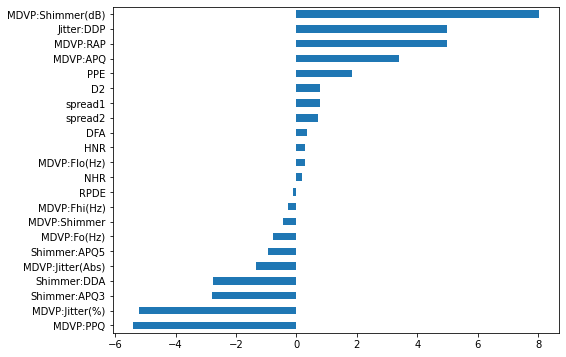

In [15]:
#Make a visualization of the coefficients 
plt.figure(figsize=(8,6))
coefficients = pd.Series(lr.coef_[0], X_train.columns)
coefficients.sort_values().plot.barh();

#Random Forest Classifier

In [16]:
#Cross validation with a random forest model

rf = RandomForestClassifier()

k = 10
scores = cross_val_score(rf, X_train, y_train, cv=k)

print(f'Accuracy score for {k} folds with Random Forest Model:', scores)
print(f'Mean score:', scores.mean())

Accuracy score for 10 folds with Random Forest Model: [0.94444444 0.94444444 0.83333333 0.83333333 0.88888889 0.88235294
 0.88235294 0.88235294 1.         0.94117647]
Mean score: 0.9032679738562092


In [17]:
#Fit with a random forest classifier

rf = RandomForestClassifier(n_jobs=-1, random_state=37)

rf.fit(X_train, y_train)

print(rf.score(X_train, y_train))



1.0


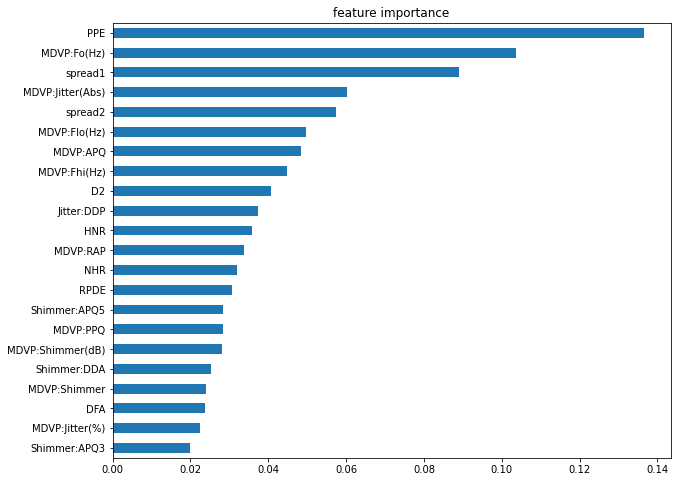

In [18]:
#Get feature importances
%matplotlib inline

importances = pd.Series(rf.feature_importances_, X_train.columns)

plt.figure(figsize=(10,8))
plt.title("feature importance")
importances.sort_values().plot.barh();


In [19]:
#Show parameters used in Random Forest model

print(rf.get_params)

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=37, verbose=0,
                       warm_start=False)>


In [20]:
#Hyperparameter tuning for Random Forest

n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(10,110,num=11)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'bootstrap':bootstrap}

rf=RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=37, n_jobs=-1)
randomsearch_result = rf_random.fit(X_train, y_train)

print('Best: %f using %s' % (randomsearch_result.best_score_, randomsearch_result.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.2min finished


Best: 0.902883 using {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}


In [21]:
#Build a second random forest model with tuned hyperparameters
#Use cross val score to train/test

rf = RandomForestClassifier(n_estimators=1200, min_samples_split=2, min_samples_leaf=1, max_features='sqrt',max_depth=110, bootstrap='False', random_state=37)

k = 10
scores = cross_val_score(rf, X_train, y_train, cv=k)

print(f'Scores:', scores)
print(f'Mean score:', scores.mean())

Scores: [0.94444444 0.94444444 0.88888889 0.83333333 0.88888889 0.88235294
 0.88235294 0.82352941 1.         1.        ]
Mean score: 0.9088235294117647


In [22]:
#Fit the model and test on test data

rf.fit(X_train, y_train)

print('Train score:', rf.score(X_train, y_train))
print('Test score:', rf.score(X_test, y_test))

Train score: 1.0
Test score: 0.9


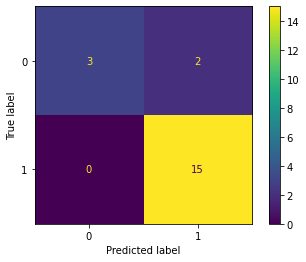

In [23]:
#confusion matrix and f1 score

plot_confusion_matrix(rf,
                      X_test,
                      y_test
                      );

In [24]:
print(classification_report(y_test, rf.predict(X_test), target_names=['No Parkinsons','Parkinsons']))

               precision    recall  f1-score   support

No Parkinsons       1.00      0.60      0.75         5
   Parkinsons       0.88      1.00      0.94        15

     accuracy                           0.90        20
    macro avg       0.94      0.80      0.84        20
 weighted avg       0.91      0.90      0.89        20



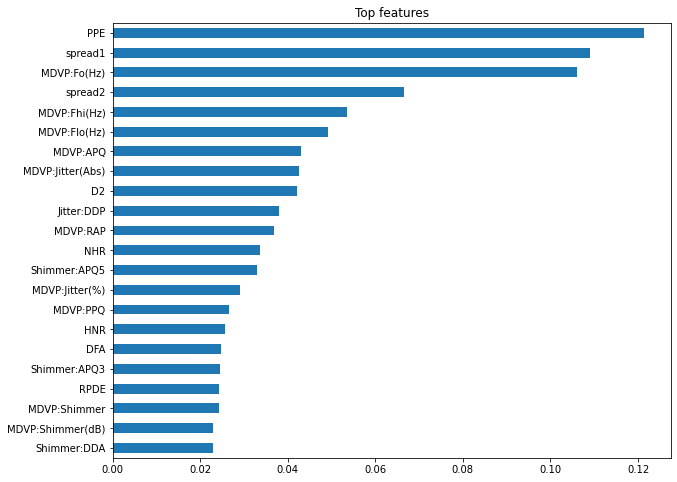

In [25]:
#Get feature importances

importances = pd.Series(rf.feature_importances_, X_train.columns)

plt.figure(figsize=(10,8))
plt.title("Top features")
importances.sort_values().plot.barh();

In [26]:
#Get permutation importance

permuter = PermutationImportance(
    rf,
    scoring='accuracy',
    n_iter=5,
    random_state=37
)

permuter.fit(X_train, y_train)

feature_names = X_train.columns.tolist()
# pd.Series(permuter.feature_importances_, feature_names).sort_values()

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

#XGBoost

In [27]:
#Make a model with XGBoost

xgb = XGBClassifier(n_estimators=100, random_state=37, n_jobs=-1)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print('Test accuracy', accuracy_score(y_test, y_pred))

k = 10
scores = cross_val_score(xgb, X_train, y_train, cv=k)

print(f'Accuracy scores with XGBoost:', scores)
print(f'Mean score:', scores.mean())

Test accuracy 0.85
Accuracy scores with XGBoost: [0.88888889 1.         0.88888889 0.88888889 0.94444444 0.88235294
 0.88235294 0.94117647 1.         1.        ]
Mean score: 0.9316993464052288


In [28]:
#XGBoost with early stopping

xgb = XGBClassifier(
    n_estimators=1000,
    max_depth=7,
    learning_rate=0.5,
    n_jobs=-1
)

eval_set = [(X_train, y_train),
            (X_test, y_test)]

xgb.fit(X_train, y_train,
        eval_set=eval_set,
        early_stopping_rounds=50)

[0]	validation_0-error:0.04	validation_1-error:0.1
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.022857	validation_1-error:0.15
[2]	validation_0-error:0.017143	validation_1-error:0.1
[3]	validation_0-error:0.005714	validation_1-error:0.2
[4]	validation_0-error:0.011429	validation_1-error:0.2
[5]	validation_0-error:0.005714	validation_1-error:0.15
[6]	validation_0-error:0	validation_1-error:0.15
[7]	validation_0-error:0	validation_1-error:0.15
[8]	validation_0-error:0	validation_1-error:0.15
[9]	validation_0-error:0	validation_1-error:0.15
[10]	validation_0-error:0	validation_1-error:0.15
[11]	validation_0-error:0	validation_1-error:0.15
[12]	validation_0-error:0	validation_1-error:0.15
[13]	validation_0-error:0	validation_1-error:0.15
[14]	validation_0-error:0	validation_1-error:0.15
[15]	validation_0-error:0	validation_1-error:0.15
[16]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Early stopping has indicated that it is already the best hyperparameters in use.

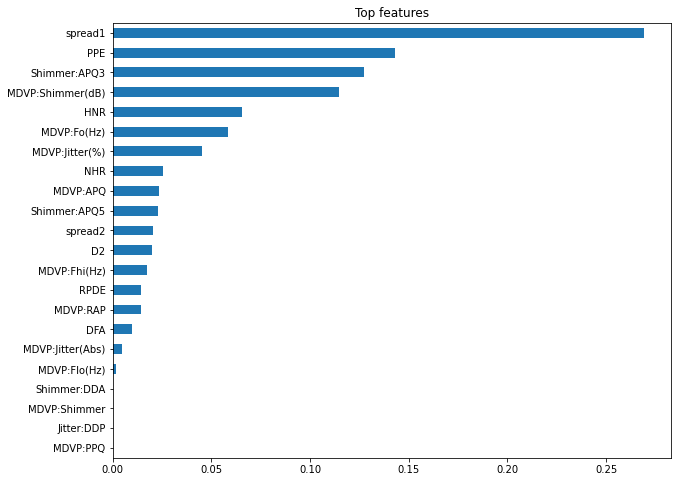

In [29]:
#Get feature importances from xgboost

importances = pd.Series(xgb.feature_importances_, X_train.columns)

plt.figure(figsize=(10,8))
plt.title("Top features")
importances.sort_values().plot.barh();

In [30]:
#Get permutation importance from xgboost

permuter = PermutationImportance(
    xgb,
    scoring='accuracy',
    n_iter=5,
    random_state=37
)

permuter.fit(X_train, y_train)

feature_names = X_train.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

In [31]:
#Make a new training set with only features with permutation importance above 0

print('shape before removing', X_train.shape)

shape before removing (175, 22)


In [32]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_xgb = X_train[features]
X_test_xgb = X_test[features]

print('shape after removing', X_train_xgb.shape)

shape after removing (175, 5)


In [33]:
#2nd XGB model with feature selection

xgb2 = XGBClassifier(
    n_estimators=1000,
    max_depth=7,
    learning_rate=0.5,
    n_jobs=-1
)

xgb2.fit(X_train_xgb, y_train)

#Cross validation
k = 10
scores = cross_val_score(xgb, X_train, y_train, cv=k)

print(f'Accuracy scores with XGBoost, 2nd model with feature engineering:', scores)
print(f'Mean score:', scores.mean())

Accuracy scores with XGBoost, 2nd model with feature engineering: [0.88888889 0.94444444 0.88888889 0.88888889 0.94444444 0.88235294
 0.88235294 0.94117647 1.         1.        ]
Mean score: 0.9261437908496731


In [34]:
#Test model on test data

y_pred = xgb2.predict(X_test_xgb)
score = accuracy_score(y_test, y_pred)


print('Test accuracy score with XGBoost 2nd model with feature engineering:', score)

Test accuracy score with XGBoost 2nd model with feature engineering: 0.9


#Partial Dependence Plots and Shap Values

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


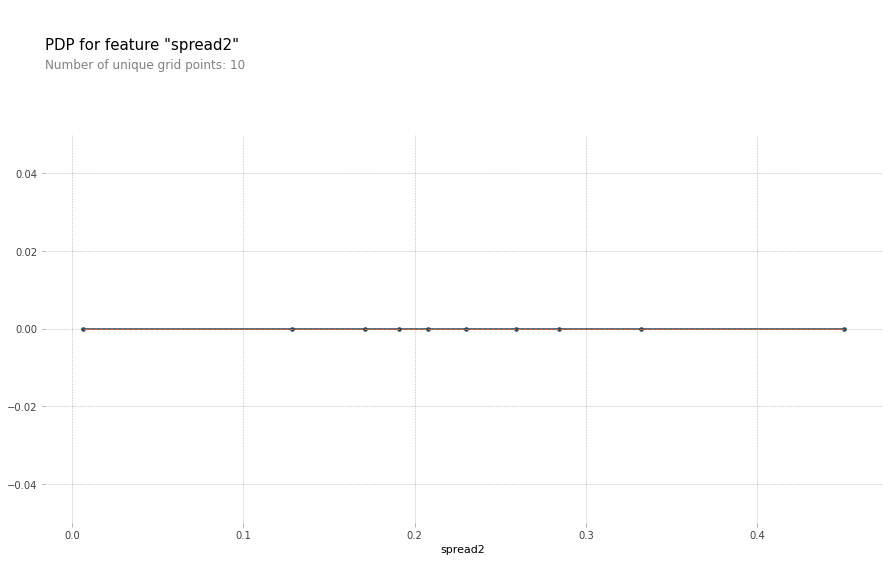

In [35]:
#Plot a partial dependence plot with one feature

feature = 'spread2'

isolated = pdp_isolate(
    model = xgb,
    dataset = X_train,
    model_features = X_train.columns,
    feature = feature
)

pdp_plot(isolated, feature_name=feature);

Interpretation: after 'spread2' surpasses ~0.16, the predicted probability that the subject has Parkinsons increases.

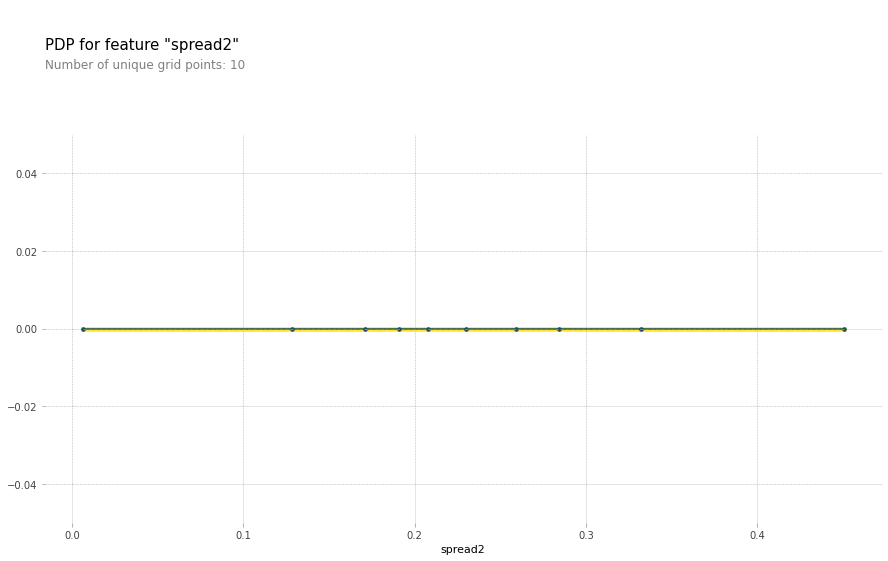

In [36]:
#Plot a pdp with ICE (individual conditional expectation) curves

pdp_plot(isolated, feature_name=feature, plot_lines=True);

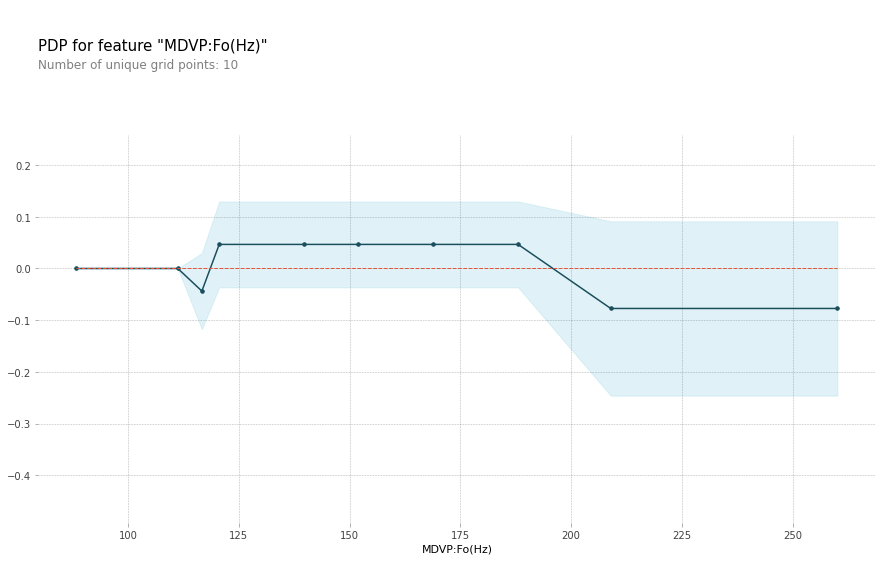

In [37]:
feature = 'MDVP:Fo(Hz)'

isolated = pdp_isolate(
    model = xgb,
    dataset = X_train,
    model_features = X_train.columns,
    feature = feature
)

pdp_plot(isolated, feature_name=feature);

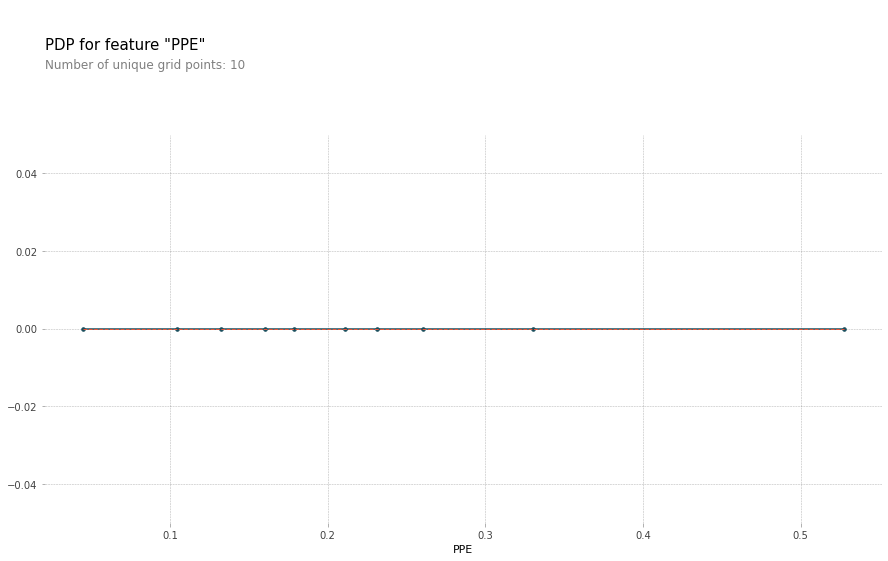

In [38]:
feature = 'PPE'

isolated = pdp_isolate(
    model = xgb,
    dataset = X_train,
    model_features = X_train.columns,
    feature = feature
)

pdp_plot(isolated, feature_name=feature);

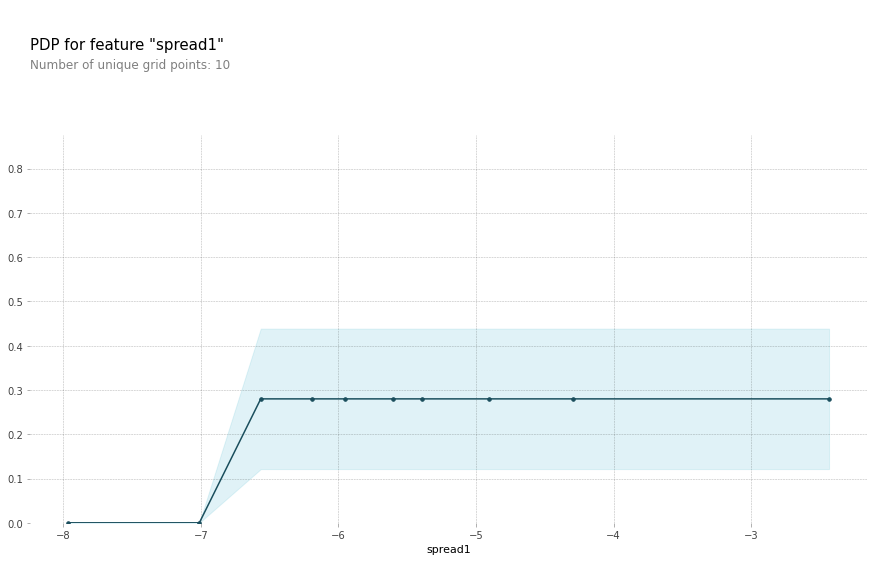

In [39]:
feature = 'spread1'

isolated = pdp_isolate(
    model = xgb,
    dataset = X_train,
    model_features = X_train.columns,
    feature = feature
)

pdp_plot(isolated, feature_name=feature);

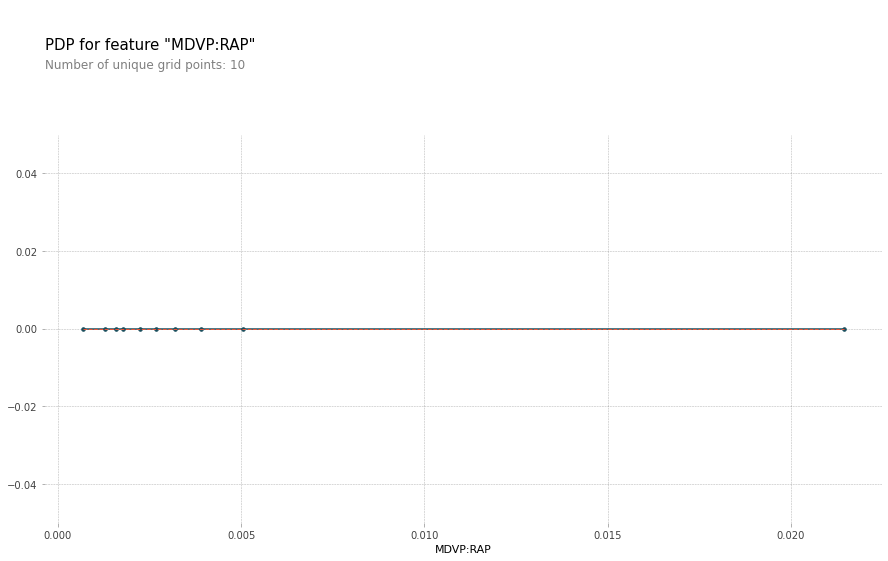

In [40]:
feature = 'MDVP:RAP'

isolated = pdp_isolate(
    model = xgb,
    dataset = X_train,
    model_features = X_train.columns,
    feature = feature
)

pdp_plot(isolated, feature_name=feature);

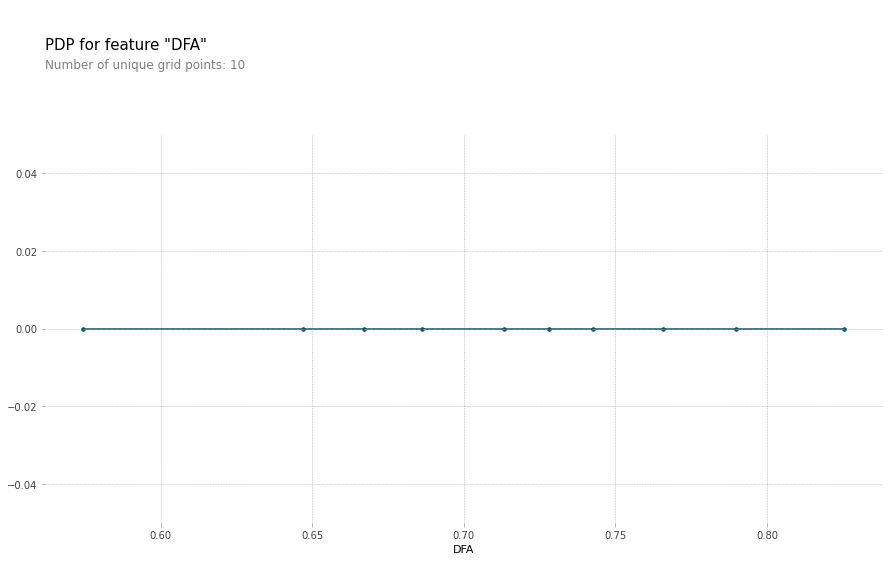

In [41]:
feature = 'DFA'

isolated = pdp_isolate(
    model = xgb,
    dataset = X_train,
    model_features = X_train.columns,
    feature = feature
)

pdp_plot(isolated, feature_name=feature);

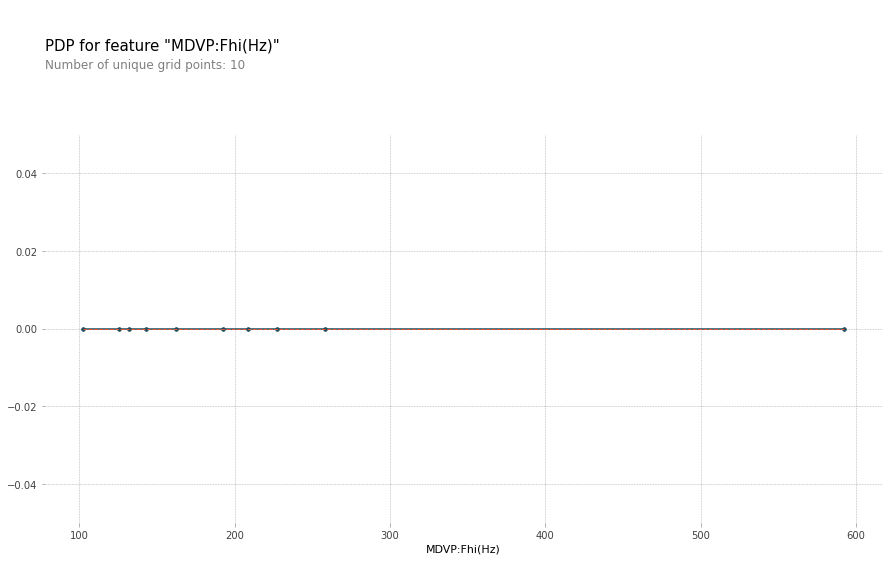

In [42]:
feature = 'MDVP:Fhi(Hz)'

isolated = pdp_isolate(
    model = xgb,
    dataset = X_train,
    model_features = X_train.columns,
    feature = feature
)

pdp_plot(isolated, feature_name=feature);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


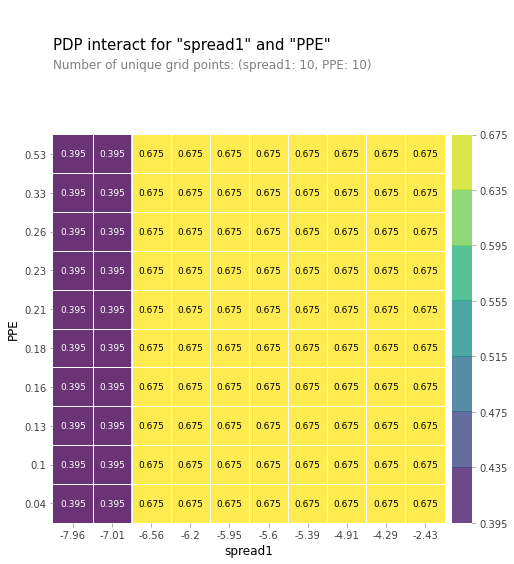

In [43]:
features = ['spread1','PPE']

interaction = pdp_interact(
    model=xgb,
    dataset=X_train,
    model_features=X_train.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [44]:
#3d plot of the grid above

pdp = interaction.pdp.pivot_table(
    values='preds',
    columns=features[0],
    index=features[1]
)

In [45]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns,
    y=pdp.index,
    z=pdp.values
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]),
        yaxis=dict(title=features[1]),
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()


#Shapley Values

In [46]:
row = X_test.iloc[[0]]
row

MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
64      229.401       252.221       221.156         0.00205          0.000009   

    MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  \
64   0.00114   0.00113     0.00342       0.01457             0.129   

    Shimmer:APQ3  Shimmer:APQ5  MDVP:APQ  Shimmer:DDA    NHR     HNR     RPDE  \
64       0.00769       0.00957   0.01016      0.02308  0.003  26.415  0.27685   

         DFA   spread1   spread2        D2       PPE  
64  0.673636 -7.496264  0.056844  2.003032  0.073581

In [47]:


explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row,
    link='logit' #for classification, this shows predicted possibilities
)

In [48]:
y_test.iloc[[0]]

64    0
Name: status, dtype: int64

In [49]:
X_test['name'] = X['name']

test_id = X_test['name']

X_test = X_test.drop(columns='name')
X_test.head()

MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
64       229.401       252.221       221.156         0.00205   
15       142.167       217.455        83.159         0.00369   
139      116.150       131.731       109.815         0.00381   
122      138.190       203.522        83.340         0.00704   
78        95.385       102.145        90.264         0.00608   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
64           0.000009   0.00114   0.00113     0.00342       0.01457   
15           0.000030   0.00157   0.00203     0.00471       0.01503   
139          0.000030   0.00181   0.00232     0.00542       0.03026   
122          0.000050   0.00406   0.00398     0.01218       0.04479   
78           0.000060   0.00331   0.00332     0.00994       0.03202   

     MDVP:Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  MDVP:APQ  Shimmer:DDA  \
64              0.129       0.00769       0.00957   0.01016      0.02308   
15              0.126       0.00772       0.00888   0.01359      0.02316   
139             0.267       0.01514       0.01812   0.02770      0.04543   
122             0.441       0.02587       0.02567   0.03220      0.07761   
78              0.263       0.01803       0.01886   0.02455      0.05408   

         NHR     HNR      RPDE       DFA   spread1   spread2        D2  \
64   0.00300  26.415  0.276850  0.673636 -7.496264  0.056844  2.003032   
15   0.00839  25.175  0.565924  0.658245 -5.340115  0.210185  2.205546   
139  0.01827  18.801  0.624811  0.696049 -5.866357  0.233070  2.445646   
122  0.01968  18.305  0.538016  0.741480 -5.418787  0.160267  2.090438   
78   0.01062  21.875  0.644954  0.779612 -5.115212  0.249494  2.017753   

          PPE  
64   0.073581  
15   0.234589  
139  0.184985  
122  0.229892  
78   0.260015

In [50]:
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

df = pd.DataFrame({
    'name': test_id,
    'pred_proba':y_pred_proba,
    'status_group': y_test
})

df = df.merge(
    X[['name','PPE','spread2','D2']]
)

In [51]:
df.head()

name  pred_proba  status_group       PPE   spread2        D2
0  phon_R01_S17_5    0.313090             0  0.073581  0.056844  2.003032
1  phon_R01_S04_4    0.693850             1  0.234589  0.210185  2.205546
2  phon_R01_S33_6    0.722519             1  0.184985  0.233070  2.445646
3  phon_R01_S31_1    0.722519             1  0.229892  0.160267  2.090438
4  phon_R01_S20_1    0.722519             1  0.260015  0.249494  2.017753

In [52]:
parkinsons = df['status_group'] == 1
healthy = ~parkinsons
right = (parkinsons) == (df['pred_proba'] > 0.50)
wrong = ~right

In [53]:
df[parkinsons & right].sample(n=10, random_state=37).sort_values(by='pred_proba')

name  pred_proba  status_group       PPE   spread2        D2
11  phon_R01_S25_2    0.653931             1  0.093193  0.144780  2.065477
1   phon_R01_S04_4    0.693850             1  0.234589  0.210185  2.205546
2   phon_R01_S33_6    0.722519             1  0.184985  0.233070  2.445646
9   phon_R01_S35_7    0.722519             1  0.454721  0.356224  3.184027
8   phon_R01_S21_6    0.722519             1  0.332086  0.375531  3.671155
5   phon_R01_S18_6    0.722519             1  0.242981  0.224852  2.642276
14  phon_R01_S18_2    0.722519             1  0.226247  0.205660  2.291558
3   phon_R01_S31_1    0.722519             1  0.229892  0.160267  2.090438
10  phon_R01_S21_2    0.722519             1  0.200423  0.315903  3.098256
4   phon_R01_S20_1    0.722519             1  0.260015  0.249494  2.017753

In [54]:
row = X_test.iloc[[4]]

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row,
    link='logit' #for classification, this shows predicted possibilities
)

In [55]:
df[healthy & wrong].sort_values(by='pred_proba')

name  pred_proba  status_group       PPE   spread2        D2
19  phon_R01_S13_1    0.693850             0  0.133867  0.266392  2.079922
15  phon_R01_S50_2    0.722519             0  0.133050  0.121952  2.657476

In [56]:
row = X_test.iloc[[15]]

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row,
    link='logit' #for classification, this shows predicted possibilities
)

In [57]:
df[healthy & right].sort_values(by='pred_proba')

name  pred_proba  status_group       PPE   spread2        D2
0   phon_R01_S17_5    0.313090             0  0.073581  0.056844  2.003032
16  phon_R01_S42_5    0.313090             0  0.100881  0.073298  2.266432
18  phon_R01_S13_4    0.364576             0  0.105993  0.291954  2.431854

In [58]:
row = X_test.iloc[[0]]

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row,
    link='logit' #for classification, this shows predicted possibilities
)

##Make Shapley plots with the Random Forest Classification model

In [59]:
#Create a dataframe showing the predicted probability and predictions for the test data

y_pred_proba = rf.predict_proba(X_test)[:, 1]

df = pd.DataFrame({
    'name': test_id,
    'pred_proba':y_pred_proba,
    'status_group': y_test
})

df = df.merge(
    X[['name','PPE','spread2','D2']]
)

In [60]:
df.head()

name  pred_proba  status_group       PPE   spread2        D2
0  phon_R01_S17_5    0.065000             0  0.073581  0.056844  2.003032
1  phon_R01_S04_4    0.793333             1  0.234589  0.210185  2.205546
2  phon_R01_S33_6    0.925000             1  0.184985  0.233070  2.445646
3  phon_R01_S31_1    0.985833             1  0.229892  0.160267  2.090438
4  phon_R01_S20_1    0.994167             1  0.260015  0.249494  2.017753

In [61]:
df.shape

(20, 6)

In [62]:
parkinsons = df['status_group'] == 1
healthy = ~parkinsons
right = (parkinsons) == (df['pred_proba'] > 0.50)
wrong = ~right

In [63]:
#Sort the predictions that were correct

df[parkinsons & right].sample(n=10, random_state=37).sort_values(by='pred_proba')

name  pred_proba  status_group       PPE   spread2        D2
11  phon_R01_S25_2    0.597500             1  0.093193  0.144780  2.065477
1   phon_R01_S04_4    0.793333             1  0.234589  0.210185  2.205546
2   phon_R01_S33_6    0.925000             1  0.184985  0.233070  2.445646
9   phon_R01_S35_7    0.980833             1  0.454721  0.356224  3.184027
3   phon_R01_S31_1    0.985833             1  0.229892  0.160267  2.090438
4   phon_R01_S20_1    0.994167             1  0.260015  0.249494  2.017753
14  phon_R01_S18_2    0.995833             1  0.226247  0.205660  2.291558
10  phon_R01_S21_2    0.995833             1  0.200423  0.315903  3.098256
8   phon_R01_S21_6    0.998333             1  0.332086  0.375531  3.671155
5   phon_R01_S18_6    0.999167             1  0.242981  0.224852  2.642276

In [64]:
#Make a shapley plot with random forest

row = X_test.iloc[[1]]

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], #required [1] to avoid 'multi-output' error message
    shap_values=shap_values[1], #[1] is the desired status group output, [0] gave the probability for 0 status group
    features=row
)

#ROC AUC

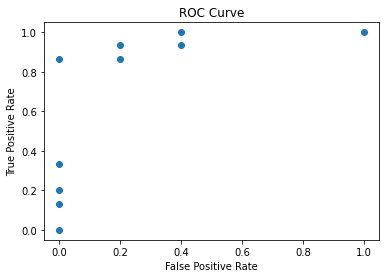

In [72]:
#Plot Receiver Operating Characteristic 

#calculate TPR and FPR at various thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

#plot the curve
plt.scatter(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [73]:
#Calculate the ROC AUC

roc_auc_score(y_test, y_pred_proba)

0.96